# `TidalCNN` part 3

There a few problems encountered in the seconds setup. 

### Contamination
We discovered that while the positives sample was likely very pure, the negatives sample contains many targets with tidal features -- many of which are rather strong. We must hope that these targets are few enough that they do not strongly affect training. To help avoid this problem, we should experiment with making images which represent a continuous transition from negative and positive targets using the pairwise combination methods (i.e. generate a linear combinations of pairs of images images with a continuous range in $\lambda$, where:

$I = \lambda I_{\mathrm{pos}} + (1-\lambda)I_{\mathrm{neg}}$.

This is something I will explore when I have a baseline accuracy that we understand from using regular augmentation.

### Rotational similarity
Overfitting was occurring too quickly. We suspected that the model was learning the augmentations. Decided to add crop (zoom) and shift augmentations to the reflected images.

## Augmentation

Training/validation/testing split should be generated from the indices of the unaugmented data. Then, integer multiples of these indices should be added to the corresponding sets. This ensures that the training/validation/test data are always distinct. In this augmentation scheme, I only perform horizontal and vertical flips to the data and the output is the $i$-band only. This gives 8 unique augmentations for each image.

### Positives/Negatives
Apply same augmentation to both positive and negative sample.

In [8]:
#!/usr/bin/env python
import numpy as np
import os,sys,multiprocessing
import scipy.ndimage
from scipy import interpolate
import random

def CropShift(augData,zoom_low,zoom_high):
    # zooms
    dx = dy = augData.shape[0]
    nChannels = augData.shape[-1]
    zoom_factor = 1-((zoom_high-zoom_low)*np.random.uniform()+zoom_low)
    dxn = dyn = int(zoom_factor*dx)
    if dxn%2: dxn-=1
    # shifts
    max_shift = int((dx-dxn)/2.)
    shifty = np.random.randint(low=-max_shift,high=max_shift)
    shiftx = np.random.randint(low=-max_shift,high=max_shift)
    img_crop = augData[max_shift+shiftx:-max_shift+shiftx,max_shift+shifty:-max_shift+shifty,:]
    x = y = np.linspace(0,1,dxn)
    xn = yn = np.linspace(0,1,dx)
    img_out = np.empty(shape=(1,*augData.shape))
    for channel in range(nChannels):
        f = interpolate.interp2d(x, y, img_crop[:,:,channel], kind='linear')
        img_out[0,:,:,channel] = f(xn,yn)
    return img_out

if __name__ == '__main__':
    
    # enviornment properties
    SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])
    
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    classIDs = ['Positive','Negative']
    
    cs_kwargs = (0.,0.4)
    for classID in classIDs:

        if classID == 'Positive':
            inData = np.load('{}{}_grizy_Images.npy'.format(dataDir,classID))[:,:,:,2].reshape(-1,128,128,1)
            inCat = np.load('{}{}_grizy_Images_cat.npy'.format(dataDir,classID)).astype(str)
        if classID == 'Negative':
            inData = np.load('{}{}_grizy_Images.npy'.format(dataDir,classID))[:5000,:,:,2].reshape(-1,128,128,1)
            inCat = np.load('{}{}_grizy_Images_cat.npy'.format(dataDir,classID)).astype(str)[:5000]
        iShape = inData.shape
        nChannels = iShape[-1]
        nRecords = iShape[0]
        dx = dy = iShape[1]

        # number of augmentations per image
        nAug = 7
        # output shape
        oShape = (nAug*nRecords,dx,dy,nChannels)
        # output data
        outData = np.empty(shape=oShape)
        # output catalogue
        outCat = np.empty(shape=(nAug*nRecords,inCat.shape[1]),dtype='S32')
        
        # output files
        outDataFile = '{}{}_i_Images-RZSAug.npy'.format(dataDir,classID)
        outCatFile = '{}{}_i_Images-RZSAug_cat.npy'.format(dataDir,classID)
    
        if os.access(outDataFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outDataFile))

        elif os.access(outCatFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outCatFile))
    
        else:
            # fill augmented data array
            for img_i in range(nRecords):
                
                imgData = inData[img_i]
                augData = np.flipud(imgData)

                outData[img_i+0*nRecords] = CropShift(augData,*cs_kwargs)
                augData = np.fliplr(augData)
                outData[img_i+1*nRecords] = CropShift(augData,*cs_kwargs)
                augData = np.flipud(augData)
                outData[img_i+2*nRecords] = CropShift(augData,*cs_kwargs)
                augData = np.rot90(augData,axes=(0,1))
                outData[img_i+3*nRecords] = CropShift(augData,*cs_kwargs)
                augData = np.flipud(augData)
                outData[img_i+4*nRecords] = CropShift(augData,*cs_kwargs)
                augData = np.fliplr(augData)
                outData[img_i+5*nRecords] = CropShift(augData,*cs_kwargs)
                augData = np.flipud(augData)
                outData[img_i+6*nRecords] = CropShift(augData,*cs_kwargs)
                
                for augm_i in range(nAug):
                    outCat[img_i+augm_i*nRecords] = inCat[img_i]
                
            # save to output file
            np.save(outDataFile,np.concatenate([inData,outData],axis=0))
            np.save(outCatFile,np.concatenate([inCat,outCat],axis=0))

### Negatives
Perform no augmentation. Make files for only the i-band images.

In [15]:
#!/usr/bin/env python
import numpy as np
import os,sys,multiprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

if __name__ == '__main__':
    
    # enviornment properties
    SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])

    dataGen = ImageDataGenerator(   
            rotation_range=0,
            width_shift_range=0.,
            height_shift_range=0.,
            fill_mode='constant',
            cval=0.0,
            vertical_flip =True,
            horizontal_flip =True,
            zoom_range = 0.,
            data_format= 'channels_last')
    
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    classIDs = ['Negative',]
    for classID in classIDs:

        inData = np.load('{}{}_grizy_Images.npy'.format(dataDir,classID))[:,:,:,2].reshape(-1,128,128,1)
        inCat = np.load('{}{}_grizy_Images_cat.npy'.format(dataDir,classID)).astype(str)
        iShape = inData.shape
        nChannels = iShape[-1]
        nRecords = iShape[0]
        dx = dy = iShape[1]
        
        # output files
        outDataFile = '{}{}_i_Images-RZSAug.npy'.format(dataDir,classID)
        outCatFile = '{}{}_i_Images-RZSAug_cat.npy'.format(dataDir,classID)
    
        if os.access(outDataFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outDataFile))

        elif os.access(outCatFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outCatFile))
    
        else:

            # save to output file
            np.save(outDataFile,inData)
            np.save(outCatFile,inCat)

Using TensorFlow backend.


## Normalization

There is now a shift. So the target is not always at the center of the image except for the for the unaugmented original images. Therefore, the normalization should be determined from the unaugmented images and applied to all of the augmented images.

In [15]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
import os,sys,warnings
warnings.filterwarnings('ignore')
from astropy.visualization import make_lupton_rgb

def Normalize_LOG10(x,window=20,is_sky=False,keepColour=True,nAug=0):
    '''Normalize (multi-band) images uisng a logarithmic scaling while preserving colour information. Input should be in linear units and be of shape (nRecords,dx,dy,nChannels).'''
    nRecords,dx,dy,nChannels = x.shape
    nOrig = int(nRecords/(nAug+1))
    
    # if sky noise is present, subtract sky level 
    if is_sky:
        x = x - np.nanmedian(x,axis=(1,2)).reshape(-1,1,1,nChannels)
    # take log of skyless image
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-5]=np.nan
    # image centre
    xc = yc = int(dx/2)
    # window dimensions
    dwinx = dwiny = int(window/2)
    # minimum value to be considered
    a_min = -3
    if keepColour:
        for i in range(nOrig):
            imgCube = x[i]
            a_max = np.nanpercentile(imgCube[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny,:],99,
                                     axis=(0,1)).reshape(1,1,nChannels)
            a_max = np.max(a_max)
            for aug in range(nAug+1):
                imgCube = x[i+aug*nOrig]
                imgCube = np.clip(imgCube,a_min=a_min,a_max=a_max)
                imgCube[np.isnan(imgCube)]=a_min
                imgCube = (imgCube - a_min)/(a_max-a_min)
                x[i+aug*nOrig] = imgCube
                    
    else:
        for i in range(nOrig):
            imgCube = x[i]
            a_max = np.nanpercentile(imgCube[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny,:],99,
                                     axis=(0,1))
            for aug in range(nAug+1):
                for j in range(nChannels):
                    imgCube = x[i+aug*nOrig]
                    img = imgCube[:,:,j]
                    img = np.clip(img,a_min=a_min,a_max=a_max[j])
                    img[np.isnan(img)]=a_min
                    img = (img - a_min)/(a_max[j]-a_min)
                    x[i+aug*nOrig,:,:,j] = img
    x[np.isnan(x)]=0.
    return x

def Normalize_Constant(x,vmin=-3,vmax=1,is_sky=False,keepColour=True):
    '''Normalize (multi-band) images uisng a fixed scaling on a logarithmic scale -- preserving colour information.'''
    nRecords,dx,dy,nChannels = x.shape
    # if sky noise is present, subtract sky level 
    if is_sky:
        x = x - np.nanmedian(x,axis=(1,2)).reshape(-1,1,1,nChannels)
    # take log of skyless image
    x = np.log10(x)
    if keepColour:
        x[np.isnan(x)] = vmin
        x[x<vmin] = vmin
        x[x>vmax] = vmax
        x = (x - vmin)/(vmax-vmin)
    return x
    

if __name__ == '__main__':
    
    classIDs = ['Positive','Negative']
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    
    for classID in classIDs:
        if classID == 'Positive':
            DataFile = '{}{}_i_Images-RZSAug.npy'.format(dataDir,classID)
            outFile = DataFile.replace('RZSAug','RZSAugNorm')
            nAug = 7
        if classID == 'Negative':  
            DataFile = '{}{}_i_Images-RZSAug.npy'.format(dataDir,classID)
            outFile = DataFile.replace('RZSAug','RZSAugNorm')
            nAug = 7
        if os.access(outFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outFile))
            continue

        x = np.load(DataFile)
        nRecords,dx,dy,nChannels = x.shape

        
        # Normalization options

        # x = Normalize_LOG10(x,window=20,is_sky=False,keepColour=True)
        x = Normalize_LOG10(x,window=20,is_sky=False,keepColour=False,nAug=nAug)
        
        # x = Normalize_Constant(x,vmin=-3,vmax=1,is_sky=False,keepColour=True)

        # save normalized data to file
        np.save(outFile,x)


## Visualize augmentation and normalizations

Visualizing the augmented images. Checking that everything worked as planned.

(9608, 128, 128, 1)
(9608, 7)
float64
1.0
0.0
157417472
0


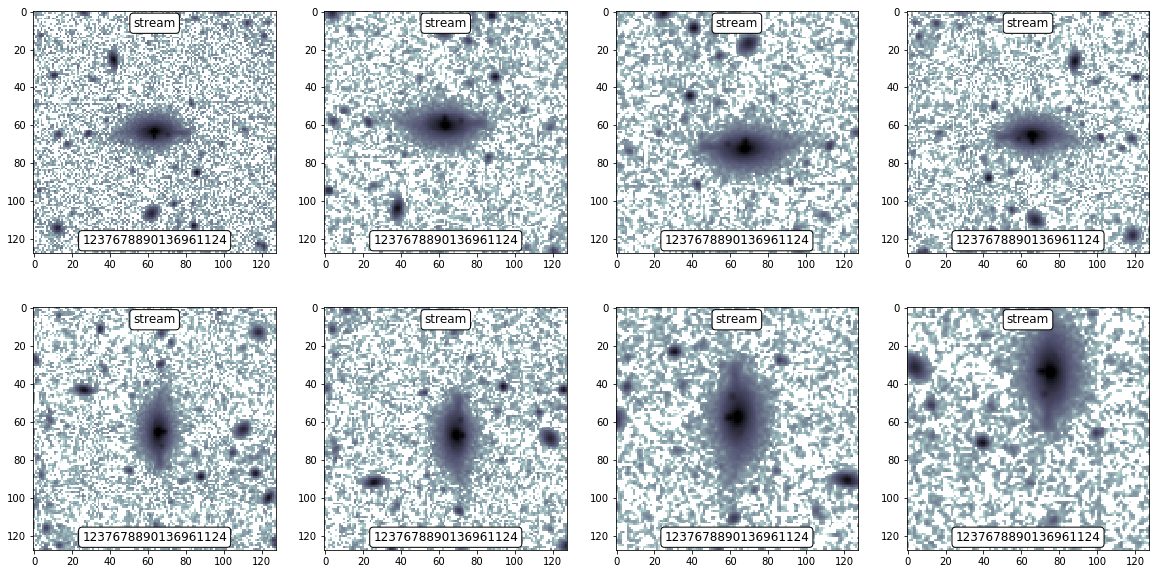

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

dataFile = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_i_Images-RZSAugNorm.npy'
catFile = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_i_Images-RZSAug_cat.npy'
inp = np.load(dataFile)
cat = np.load(catFile)
inp_shape = inp.shape
dx = dy = inp_shape[1]
print(inp.shape)
print(cat.shape)
print(inp.dtype)
print(np.max(inp))
print(np.min(inp))
inp1d = inp.flatten()
print(len(inp1d))
print(len(inp1d[np.isnan(inp1d)]))

fig,axarr = plt.subplots(2,4,figsize=(20,10))
axarr = axarr.flatten()

# number between 0 and 1200
index = 600
nOrig = 1201

indices = [index+i*nOrig for i in range(8)]

for i,index in enumerate(indices):
    objID = cat[index][0]
    morphID = cat[index][1]
    
    axarr[i].imshow(inp[index][:,:,0],vmin=0,vmax=1,cmap='bone_r')
    axarr[i].text(0.5,0.025,'{}'.format(objID),transform=axarr[i].transAxes,ha='center',va='bottom',fontsize=12,
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    axarr[i].text(0.5,0.975,'{}'.format(morphID),transform=axarr[i].transAxes,ha='center',va='top',fontsize=12,
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


(40000, 128, 128, 1)
(40000, 7)
float64
1.0
0.0
655360000
0


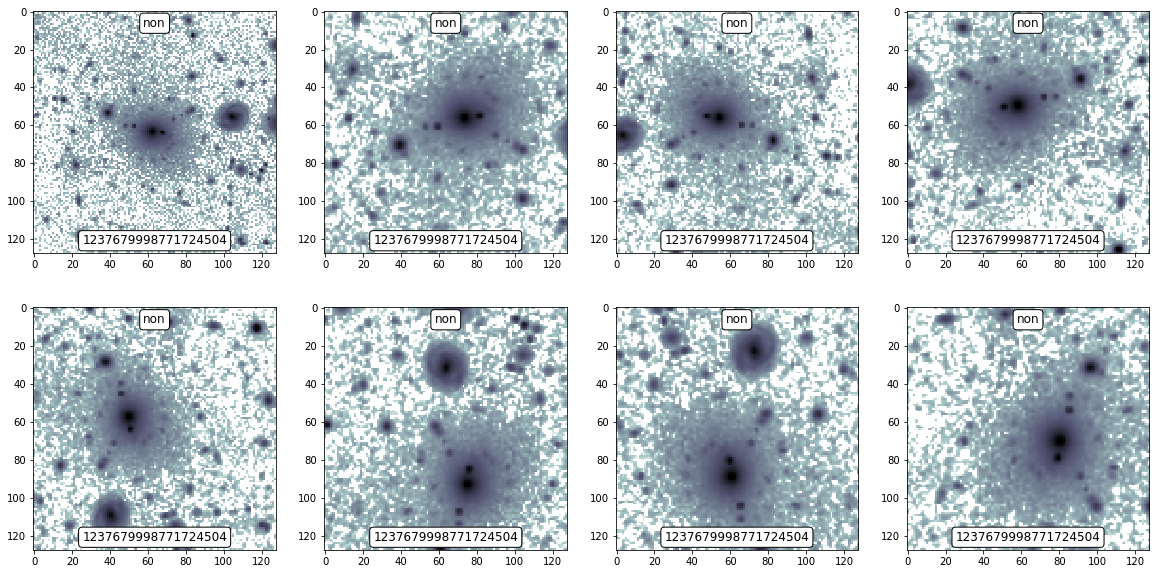

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

dataFile = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Negative_i_Images-RZSAugNorm.npy'
catFile = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Negative_i_Images-RZSAug_cat.npy'
inp = np.load(dataFile)
cat = np.load(catFile)
inp_shape = inp.shape
dx = dy = inp_shape[1]
print(inp.shape)
print(cat.shape)
print(inp.dtype)
print(np.max(inp))
print(np.min(inp))
inp1d = inp.flatten()
print(len(inp1d))
print(len(inp1d[np.isnan(inp1d)]))

fig,axarr = plt.subplots(2,4,figsize=(20,10))
axarr = axarr.flatten()

# number between 0 and 1200
index = 15
nOrig = 5000
# indices = np.random.choice(nOrig,8,replace=False)
indices = [index+i*nOrig for i in range(8)]

for i,index in enumerate(indices):
    objID = cat[index][0]
    morphID = cat[index][1]
    
    axarr[i].imshow(inp[index][:,:,0],vmin=0,vmax=1,cmap='bone_r')
    axarr[i].text(0.5,0.025,'{}'.format(objID),transform=axarr[i].transAxes,ha='center',va='bottom',fontsize=12,
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    axarr[i].text(0.5,0.975,'{}'.format(morphID),transform=axarr[i].transAxes,ha='center',va='top',fontsize=12,
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


## Applying model to new data

### Import modules

In [1]:
#!/usr/bin/env python

import os,sys,json
import keras
from keras import backend as K
from keras.models import Model,load_model
from keras.layers import Input,Dense,Dropout,Flatten
from keras.utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn import model_selection as md
from keras import regularizers
import numpy as np

Using TensorFlow backend.


### Define model

In [2]:
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        
######################################################################
def HSC_Subaru_CNN(args):
    
    dx,dy,nChannels = args
    
    # convolution model
    inputs = Input(shape=(dx,dy,nChannels), name='main_input')
    # first conv layer
    x = Conv2D(32, kernel_size=(5,5),activation='relu',
               padding='same',strides=(1, 1),name='Conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
    #x = Dropout(0.5,name='Drop_C1')(x)
    # second conv layer
    x = Conv2D(64, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
    #x = Dropout(0.25,name='Drop_C2')(x)
    # third conv layer
    x = Conv2D(128, kernel_size=(2,2),activation='relu',
               padding='same',strides=(1, 1),name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
    #x = Dropout(0.25,name='Drop_C3')(x)
    # fourth conv layer
    x = Conv2D(128, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_4')(x)
    # x = Dropout(0.25,name='Drop_C4')(x)
    # flatten for fully connected layers
    x = Flatten(name='Flatten')(x)

    # Fully Connected Layer
    x = Dense(64,activation='relu',name='Dense_1')(x)
    x = Dropout(0.5,name='DropFCL_1')(x)
    x = Dense(16,activation='relu',name='Dense_2')(x)
    x = Dropout(0.5,name='DropFCL_2')(x)
    x = Dense(1,activation='sigmoid',name='Dense_3')(x)

    # connect and compile
    model = Model(inputs=inputs,outputs=x)
    model.compile(optimizer=keras.optimizers.Adadelta(), 
                  loss='binary_crossentropy',metrics=['accuracy'])
    return model
######################################################################

### Load data

In [2]:
classIDs = ['Negative','Positive']
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
fileNames = ['{}{}_i_Images-RZSAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RZSAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

np.random.seed(0)
negative_subsample = 10000

tar = np.array([])
inp = np.array([])
# Negatives
#indices_neg = np.random.choice(np.arange(negative_total),negative_samples,replace=False)
inp_neg = np.load(fileNames[0])[:negative_subsample] # [indices_neg]
print('Negatives:',inp_neg.shape)
n_neg = inp_neg.shape[0]
n_negOrig = 5000
f_negAug = int(n_neg/n_negOrig)-1
print('Number of augmentations per original image:', f_negAug)
tar_neg = np.append(tar,np.ones(n_neg)*0)
cat_neg = np.load(catNames[0])[:negative_subsample]


# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
n_pos = inp_pos.shape[0]
n_posOrig = 1201
f_posAug = int(n_pos/n_posOrig)-1
print('Number of augmentations per original image:', f_posAug)
tar_pos = np.ones(n_pos)
cat_pos = np.load(catNames[1])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0).reshape(-1,128,128,1)
tar = np.append(tar_neg,tar_pos)
cat = np.concatenate([cat_neg,cat_pos],axis=0)


Negatives: (10000, 128, 128, 1)
Number of augmentations per original image: 1
Positives: (9608, 128, 128, 1)
Number of augmentations per original image: 7


### Split data

In [3]:
def split_data(inp,tar,cat,n_negOrig,n_neg,n_posOrig,n_pos,
               train_valid_split=0.3,valid_test_split=0.5,randomState=0):
    
    f_negAug = int(n_neg/n_negOrig)-1
    f_posAug = int(n_pos/n_posOrig)-1

    # indices of the original pre-augmentation images
    indices_neg0 = np.arange(n_negOrig).astype(int)
    indices_pos0 = np.arange(n_posOrig).astype(int)+n_neg

    # this randomstate ensures we would have the same images if we did this again
    randomState = 0
    indices_neg_train0,indices_neg_valid0 = md.train_test_split(indices_neg0,test_size=train_valid_split, random_state=randomState)
    indices_neg_valid0,indices_neg_test0  = md.train_test_split(indices_neg_valid0,test_size=valid_test_split, random_state=randomState)
    indices_pos_train0,indices_pos_valid0 = md.train_test_split(indices_pos0,test_size=train_valid_split, random_state=randomState)
    indices_pos_valid0,indices_pos_test0  = md.train_test_split(indices_pos_valid0,test_size=valid_test_split, random_state=randomState)

    indices_neg_train = np.array([]).astype(int)
    indices_neg_valid = np.array([]).astype(int)
    indices_neg_test = np.array([]).astype(int)
    indices_pos_train = np.array([]).astype(int)
    indices_pos_valid = np.array([]).astype(int)
    indices_pos_test = np.array([]).astype(int)

    # now incorporate augmented images into each dataset
    for i in range(f_negAug+1):
        indices_neg_train = np.concatenate([indices_neg_train,indices_neg_train0+i*n_negOrig])
        indices_neg_valid = np.concatenate([indices_neg_valid,indices_neg_valid0+i*n_negOrig])
        indices_neg_test = np.concatenate([indices_neg_test,indices_neg_test0+i*n_negOrig])
    for i in range(f_posAug+1):
        indices_pos_train = np.concatenate([indices_pos_train,indices_pos_train0+i*n_posOrig])
        indices_pos_valid = np.concatenate([indices_pos_valid,indices_pos_valid0+i*n_posOrig])
        indices_pos_test = np.concatenate([indices_pos_test,indices_pos_test0+i*n_posOrig])
    print('Negatives:', len(indices_neg_train),len(indices_neg_valid),len(indices_neg_test))
    print('Positives:', len(indices_pos_train),len(indices_pos_valid),len(indices_pos_test))

    # join
    indices_train = np.concatenate([indices_neg_train,indices_pos_train])
    indices_valid = np.concatenate([indices_neg_valid,indices_pos_valid])
    indices_test = np.concatenate([indices_neg_test,indices_pos_test])

    # # Now apply to full data matrix
    tar_train = tar[indices_train]
    inp_train = inp[indices_train]
    cat_train = cat[indices_train]
    tar_valid = tar[indices_valid]
    inp_valid = inp[indices_valid]
    cat_valid = cat[indices_valid]
    tar_test = tar[indices_test]
    inp_test = inp[indices_test]
    cat_test = cat[indices_test]
    return inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test



In [5]:
nRecords,dx,dy,nChannels = inp.shape
nClasses=len(classIDs)
#del new_inp,new_cat

batch_size = 32
epochs=30
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 3
patience = 999
label = 'HSC-Subaru'
          
randomStates = np.arange(10)

for randomState in randomStates:

    modelFile = modelDir+'{}_Binary_RS-{}_v{}_{}.h5'
    historyFile = modelDir+'{}_Binary_RS-{}_v{}_{}_history.json'
    if os.access(modelFile.format(label,randomState,version,update),0): continue

    modelFile = modelFile.format(label,randomState,version,update)
    print('Model will save as: {}'.format(modelFile))
    historyFile = historyFile.format(label,randomState,version,update)
    print('History will save as: {}'.format(historyFile))
    
    mcp_file = modelFile.replace('.h5','_wgts.hdf5')
    early_stopping = EarlyStopping(monitor='val_acc', patience=patience, verbose=1, mode='max')
    mcp_save = ModelCheckpoint(mcp_file, save_best_only=True, monitor='val_acc', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

    args = (dx,dy,nChannels)
    model = HSC_Subaru_CNN(args)
    
    inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test = split_data(inp,tar,cat,
                                                                                                       5000,10000,1201,9608,randomState=randomState)
    
    model.summary()

    model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
              batch_size=batch_size,validation_data=[inp_valid,tar_valid],
              callbacks=[early_stopping, mcp_save]) 
    
    save_model_history(model=model,history_filename=historyFile)
    if os.access(mcp_file,0):
        model.load_weights(mcp_file)
        os.remove(mcp_file)
    model.save(modelFile)



Model will save as: /home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/HSC-Subaru_Binary_RS-1_v3_0.h5
History will save as: /home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/HSC-Subaru_Binary_RS-1_v3_0_history.json
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 128, 128, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 128, 128, 32)      832       
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_

Train on 13720 samples, validate on 2940 samples
Epoch 1/30
13720/13720 [==============================] - 7s 507us/step - loss: 0.6686 - acc: 0.5860 - val_loss: 0.6061 - val_acc: 0.6891
Epoch 2/30
13720/13720 [==============================] - 5s 393us/step - loss: 0.6306 - acc: 0.6698 - val_loss: 0.5941 - val_acc: 0.6748
Epoch 3/30
13720/13720 [==============================] - 5s 385us/step - loss: 0.6023 - acc: 0.6992 - val_loss: 0.5678 - val_acc: 0.7201
Epoch 4/30
13720/13720 [==============================] - 5s 391us/step - loss: 0.5947 - acc: 0.7063 - val_loss: 0.5598 - val_acc: 0.7272
Epoch 5/30
13720/13720 [==============================] - 5s 385us/step - loss: 0.5856 - acc: 0.7147 - val_loss: 0.6069 - val_acc: 0.6844
Epoch 6/30
13720/13720 [==============================] - 5s 383us/step - loss: 0.5827 - acc: 0.7130 - val_loss: 0.5479 - val_acc: 0.7364
Epoch 7/30
13720/13720 [==============================] - 5s 383us/step - loss: 0.5814 - acc: 0.7179 - val_loss: 0.5658 - v

KeyboardInterrupt: 

## Examine model long-term performance



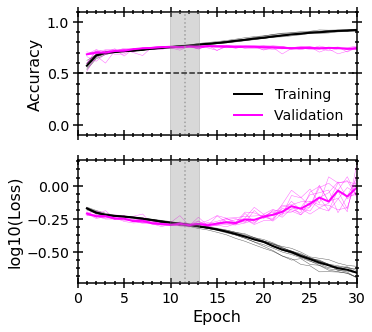

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from keras.models import load_model
from glob import glob


epochs=30
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 3
label = 'HSC-Subaru'

modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'

modelFiles = list(sorted(glob('{}{}_Binary_RS-*_v{}_{}.h5'.format(modelDir,label,version,update))))

historyFiles = list(sorted(glob('{}{}_Binary_RS-*_v{}_{}_history.json'.format(modelDir,label,version,update))))

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
fig,axarr = plt.subplots(2,1,figsize=(5,5),sharex=True)
fig.subplots_adjust(hspace=0.2)

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True,right=True,size=10,width=1.5)
    ax.tick_params(axis='both',which='minor',direction='inout',size=4)

ax = axarr[1]
ax.set_xlabel(r'Epoch',fontsize=16)
ax.set_ylabel(r'log10(Loss)',fontsize=16)
ax.set_xlim(0,30)
ax = axarr[0]
ax.set_ylabel(r'Accuracy',fontsize=16)
ax.set_xlim(0,30)
ax.set_ylim(-0.1,1.1)

stats = np.empty(shape=(30,4,len(historyFiles)))

for i,fileName in enumerate(historyFiles):
    with open(fileName) as f:
        history = json.load(f)
    acc = history['acc']
    stats[:,0,i]=acc
    vacc = history['val_acc']
    stats[:,1,i]=vacc
    loss = history['loss']
    stats[:,2,i]=loss
    vloss = history['val_loss']
    stats[:,3,i]=vloss
    epochs = np.arange(len(acc))+1
    
    axarr[0].plot(epochs,acc,color='black',linestyle='solid',alpha=0.6,linewidth=0.5)
    axarr[0].plot(epochs,vacc,color='magenta',linestyle='solid',alpha=0.6,linewidth=0.5)
    
    axarr[1].plot(epochs,np.log10(loss),color='black',linestyle='solid',alpha=0.6,linewidth=0.5)
    axarr[1].plot(epochs,np.log10(vloss),color='magenta',linestyle='solid',alpha=0.6,linewidth=0.5)

med_acc = np.nanmedian(stats[:,0,:],axis=1)
med_vacc = np.nanmedian(stats[:,1,:],axis=1)
stopping = np.argmin(stats[:,3,:],axis=0)

med_loss = np.nanmedian(stats[:,2,:],axis=1)
med_vloss = np.nanmedian(stats[:,3,:],axis=1)
axarr[0].plot(epochs,med_acc,linewidth=2,c='black',label='Training')
axarr[0].plot(epochs,med_vacc,linewidth=2,c='magenta',label='Validation')
ax.legend(frameon=False,loc=4)

mean_stop = np.nanmean(stopping)
std_stop = np.nanstd(stopping)
for ax in axarr:
    
    ax.axvline(mean_stop,c='darkgrey',linestyle='dotted',linewidth=1.5)
    ax.axvspan(mean_stop-std_stop,mean_stop+std_stop, alpha=0.3, color='grey',zorder=9)
    
axarr[1].plot(epochs,np.log10(med_loss),linewidth=2,c='black')
axarr[1].plot(epochs,np.log10(med_vloss),linewidth=2,c='magenta')

axarr[0].axhline(y=0.5,linestyle='dashed',c='black')

fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_30epochs_acc-loss.pdf'.format(version,update),
            bbox_inches='tight')

## Histograms

Negatives: (10000, 128, 128, 1)
Number of augmentations per original image: 1
Positives: (9608, 128, 128, 1)
Number of augmentations per original image: 7
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Negatives: 7000 1500 1500
Positives: 6720 1440 1448


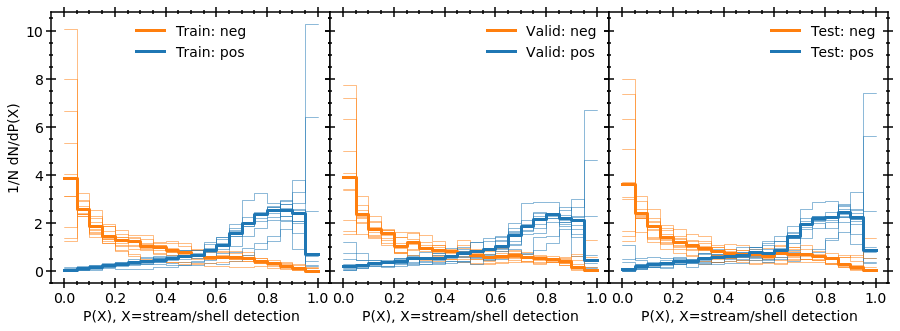

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from sklearn import model_selection as md
from keras.models import load_model
from glob import glob
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
from glob import glob

def Hist_and_Plot(ax,xedges,out,tar,classID):
    if classID == 1: colour = 'C0'
    if classID == 0: colour = 'C1'
    H,xedges = np.histogram(out.flatten()[tar==classID],bins=xedges,density=False)
    H = H/widths/np.sum(H)
    ax.step(x=xedges,y=np.append(H,H[-1]),color=colour,where='post',linewidth=0.5)
    return H

def Plot_H(ax,H,xedges,args):
    colour,linewidth,linestyle,label = args
    median = np.nanmedian(H,axis=0)
    median = median/np.nansum(median)/widths
    ax.step(x=xedges,y=np.append(median,median[-1]),color=colour,where='post',
                  linewidth=linewidth,linestyle=linestyle,label=label)

classIDs = ['Negative','Positive']
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
fileNames = ['{}{}_i_Images-RZSAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RZSAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

np.random.seed(0)
negative_subsample = 10000

tar = np.array([])
inp = np.array([])
# Negatives
#indices_neg = np.random.choice(np.arange(negative_total),negative_samples,replace=False)
inp_neg = np.load(fileNames[0])[:negative_subsample] # [indices_neg]
print('Negatives:',inp_neg.shape)
n_neg = inp_neg.shape[0]
n_negOrig = 5000
f_negAug = int(n_neg/n_negOrig)-1
print('Number of augmentations per original image:', f_negAug)
tar_neg = np.append(tar,np.ones(n_neg)*0)
cat_neg = np.load(catNames[0])[:negative_subsample]


# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
n_pos = inp_pos.shape[0]
n_posOrig = 1201
f_posAug = int(n_pos/n_posOrig)-1
print('Number of augmentations per original image:', f_posAug)
tar_pos = np.ones(n_pos)
cat_pos = np.load(catNames[1])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0).reshape(-1,128,128,1)
tar = np.append(tar_neg,tar_pos)
cat = np.concatenate([cat_neg,cat_pos],axis=0)

epochs=100
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 3
label = 'HSC-Subaru'

# Histogram params
xmin,xmax=0.,1.
nbins = 20
xedges = np.linspace(xmin,xmax,nbins+1)
widths = (xedges[1:]-xedges[:-1])
xcs = xedges[:-1]+widths/2.

# figure initialization
fig,axarr = plt.subplots(1,3,figsize=(15,5),sharey=True)
fig.subplots_adjust(wspace=0.)
for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True,right=True,size=10,width=1.5)
    ax.tick_params(axis='both',which='minor',direction='inout',size=4)

randomStates = np.arange(10)

H_train_neg = np.empty(shape=(len(randomStates),nbins))
H_train_pos = np.empty(shape=(len(randomStates),nbins))
H_valid_neg = np.empty(shape=(len(randomStates),nbins))
H_valid_pos = np.empty(shape=(len(randomStates),nbins))
H_test_neg = np.empty(shape=(len(randomStates),nbins))
H_test_pos = np.empty(shape=(len(randomStates),nbins))

for ii,randomState in enumerate(randomStates):
    print('Random State: {}'.format(randomState))
    fileName = '{}{}_Binary_RS-{}_v{}_{}.h5'.format(modelDir,label,randomState,version,update)
    model = load_model(fileName)
    inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test = split_data(inp,tar,cat,
    print('Loaded Model.\n')                                                                                                   5000,10000,1201,9608,randomState=randomState)
    
    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))

    H_train_neg[ii] = Hist_and_Plot(axarr[0],xedges,out_train,tar_train,classID=0)
    H_valid_neg[ii] = Hist_and_Plot(axarr[1],xedges,out_valid,tar_valid,classID=0)
    H_test_neg[ii] = Hist_and_Plot(axarr[2],xedges,out_test,tar_test,classID=0)
    
    H_train_pos[ii] = Hist_and_Plot(axarr[0],xedges,out_train,tar_train,classID=1)
    H_valid_pos[ii] = Hist_and_Plot(axarr[1],xedges,out_valid,tar_valid,classID=1)
    H_test_pos[ii] = Hist_and_Plot(axarr[2],xedges,out_test,tar_test,classID=1)

args = ('C1',3,'solid','Train: neg')
Plot_H(axarr[0],H_train_neg,xedges,args)
args = ('C0',3,'solid','Train: pos')
Plot_H(axarr[0],H_train_pos,xedges,args)
axarr[0].legend(frameon=False)

args = ('C1',3,'solid','Valid: neg')
Plot_H(axarr[1],H_valid_neg,xedges,args)
args = ('C0',3,'solid','Valid: pos')
Plot_H(axarr[1],H_valid_pos,xedges,args)
axarr[1].legend(frameon=False)

args = ('C1',3,'solid','Test: neg')
Plot_H(axarr[2],H_test_neg,xedges,args)
args = ('C0',3,'solid','Test: pos')
Plot_H(axarr[2],H_test_pos,xedges,args)
axarr[2].legend(frameon=False)

axarr[0].set_ylabel(r'1/N dN/dP(X)')

for ax in axarr.flat:
    ax.set_xlim(xmin-0.05,xmax+0.05)
    ax.set_xlabel(r'P(X), X=stream/shell detection')
    
fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_30epochs_Px.pdf'.format(version,update),
            bbox_inches='tight')

In [39]:
fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_100epochs_Px.pdf'.format(version,update),
            bbox_inches='tight')

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from sklearn import model_selection as md
from keras.models import load_model
from glob import glob
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
from glob import glob

classIDs = ['Negative','Positive']
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
fileNames = ['{}{}_i_Images-RZSAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RZSAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

np.random.seed(0)
negative_subsample = 10000

tar = np.array([])
inp = np.array([])
# Negatives
#indices_neg = np.random.choice(np.arange(negative_total),negative_samples,replace=False)
inp_neg = np.load(fileNames[0])[:negative_subsample] # [indices_neg]
print('Negatives:',inp_neg.shape)
n_neg = inp_neg.shape[0]
n_negOrig = 5000
f_negAug = int(n_neg/n_negOrig)-1
print('Number of augmentations per original image:', f_negAug)
tar_neg = np.append(tar,np.ones(n_neg)*0)
cat_neg = np.load(catNames[0])[:negative_subsample]


# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
n_pos = inp_pos.shape[0]
n_posOrig = 1201
f_posAug = int(n_pos/n_posOrig)-1
print('Number of augmentations per original image:', f_posAug)
tar_pos = np.ones(n_pos)
cat_pos = np.load(catNames[1])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0).reshape(-1,128,128,1)
tar = np.append(tar_neg,tar_pos)
cat = np.concatenate([cat_neg,cat_pos],axis=0)

epochs=30
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 3
label = 'HSC-Subaru'

Negatives: (10000, 128, 128, 1)
Number of augmentations per original image: 1
Positives: (9608, 128, 128, 1)
Number of augmentations per original image: 7


Negatives: 7000 1500 1500
Positives: 6720 1440 1448
0
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
1
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
2
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
3
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
4
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
5
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
6
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
7
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
8
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
9


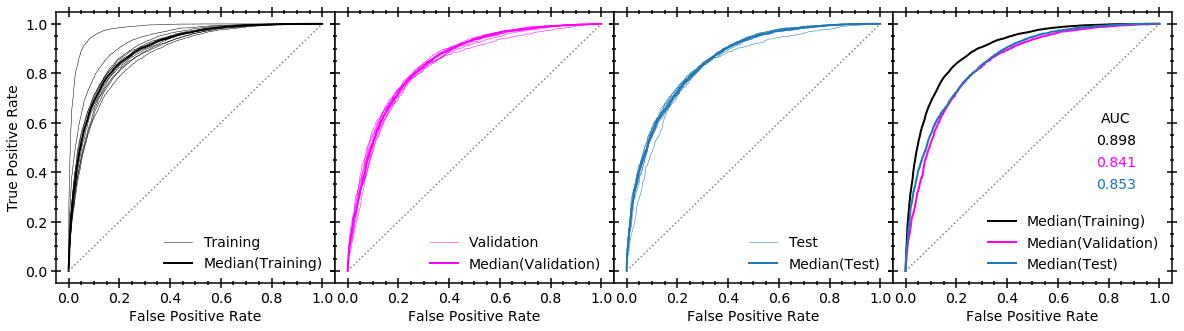

In [11]:
from sklearn import metrics

fig,axarr = plt.subplots(1,4,figsize=(20,5),sharey=True)
fig.subplots_adjust(wspace=0.)
for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True,right=True,size=10,width=1.5)
    ax.tick_params(axis='both',which='minor',direction='inout',size=4)
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)
axarr[0].set_ylabel('True Positive Rate')

randomStates = np.arange(10)

fpr_all = np.linspace(0,1,1001)
tpr_train = np.empty(shape=(len(randomStates),1001))
tpr_valid = np.empty(shape=(len(randomStates),1001))
tpr_test = np.empty(shape=(len(randomStates),1001))

for i,randomState in enumerate(randomStates):
    
    fileName = '{}{}_Binary_RS-{}_v{}_{}.h5'.format(modelDir,label,randomState,version,update)
    model = load_model(fileName)
    args = (train_valid_split,valid_test_split)
    inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test = split_data(inp,tar,cat,
                                                                                                       5000,10000,1201,9608,randomState=randomState)
    
    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))
    print(i)
    
    ax = axarr[0]
    fpr, tpr, thresholds = metrics.roc_curve(tar_train, out_train)
    auc = np.trapz(tpr,fpr)
    tpr = np.interp(fpr_all,fpr,tpr,left=0.,right=1)
    tpr[0]=0.
    tpr[-1]=1.
    tpr_train[i]=tpr
    ax.plot(fpr_all,tpr,color='black',linewidth=0.5,label=('Training' if randomState==randomStates[0] else None))

    ax = axarr[1]
    fpr, tpr, thresholds = metrics.roc_curve(tar_valid, out_valid)
    auc = np.trapz(tpr,fpr)
    tpr = np.interp(fpr_all,fpr,tpr,left=0.,right=1)
    tpr[0]=0.
    tpr[-1]=1.
    tpr_valid[i]=tpr
    ax.plot(fpr_all,tpr,color='magenta',linewidth=0.5,label=('Validation' if randomState==randomStates[0] else None))

    ax = axarr[2]
    fpr, tpr, thresholds = metrics.roc_curve(tar_test, out_test)
    auc = np.trapz(tpr,fpr)
    tpr = np.interp(fpr_all,fpr,tpr,left=0.,right=1)
    tpr[0]=0.
    tpr[-1]=1.
    tpr_test[i]=tpr
    ax.plot(fpr_all,tpr,color='C0',linewidth=0.5,label=('Test' if randomState==randomStates[0] else None))

tpr_train_med = np.nanmedian(tpr_train,axis=0)
tpr_valid_med = np.nanmedian(tpr_valid,axis=0)
tpr_test_med = np.nanmedian(tpr_test,axis=0)

axarr[3].text(0.8,0.58,r'AUC',transform=axarr[3].transAxes,va='bottom',ha='center',color='black')

axarr[0].plot(fpr_all,tpr_train_med,color='black',linewidth=2,label='Median(Training)')
auc = np.trapz(tpr_train_med,fpr_all)
axarr[3].text(0.8,0.5,r'{}'.format('%0.3f'%auc),transform=axarr[3].transAxes,va='bottom',ha='center',color='black' )

axarr[1].plot(fpr_all,tpr_valid_med,color='magenta',linewidth=2,label='Median(Validation)')
auc = np.trapz(tpr_valid_med,fpr_all)
axarr[3].text(0.8,0.42,r'{}'.format('%0.3f'%auc),transform=axarr[3].transAxes,va='bottom',ha='center',color='magenta' )

axarr[2].plot(fpr_all,tpr_test_med,color='C0',linewidth=2,label='Median(Test)')
auc = np.trapz(tpr_test_med,fpr_all)
axarr[3].text(0.8,0.34,r'{}'.format('%0.3f'%auc),transform=axarr[3].transAxes,va='bottom',ha='center',color='C0' )

axarr[3].plot(fpr_all,tpr_train_med,color='black',linewidth=2,label='Median(Training)')
axarr[3].plot(fpr_all,tpr_valid_med,color='magenta',linewidth=2,label='Median(Validation)')
axarr[3].plot(fpr_all,tpr_test_med,color='C0',linewidth=2,label='Median(Test)')

for ax in axarr.flat:
    ax.plot([-0.0,1.0],[-0.0,1.0],linestyle='dotted',c='grey')
    ax.set_xlabel('False Positive Rate')
    ax.legend(frameon=False,loc=4)

fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_30epochs_ROC_test.pdf'.format(version,update),
            bbox_inches='tight')

Negatives: (10000, 128, 128, 1)
Number of augmentations per original image: 1
Positives: (9608, 128, 128, 1)
Number of augmentations per original image: 7
Negatives: 7000 1500 1500
Positives: 6720 1440 1448
Test:
TPR: 0.8011049723756906
FPR: 0.25666666666666665
TNR: 0.7433333333333333
FNR: 0.19889502762430938
Validation:
TPR: 0.7777777777777778
FPR: 0.244
TNR: 0.756
FNR: 0.2222222222222222
0.7645861601085482
1500
Confusion matrix, without normalization
[[1115  288]
 [ 385 1160]]
[[1500]
 [1448]]
[1500 1448]
Normalized confusion matrix
[[0.743 0.199]
 [0.257 0.801]]
[[1.]
 [1.]]
[1. 1.]


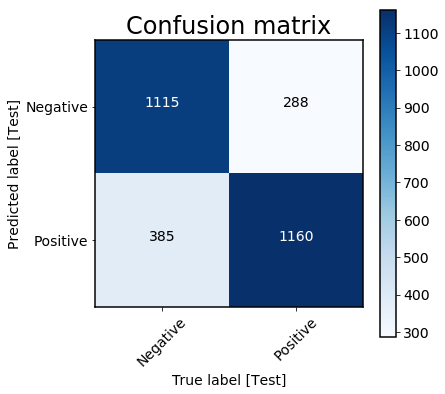

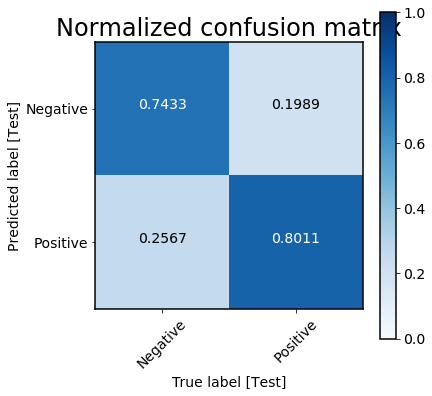

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from sklearn import model_selection as md
from keras.models import load_model
from glob import glob
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
from glob import glob

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(ax, cm, classes, update, version,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(np.sum(cm,axis=0)[:, np.newaxis])
    print(np.sum(cm,axis=0))
    
    if normalize:
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else :
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=16)
    cb = plt.colorbar(im1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #ax.text(0.5,0.05,'model_v{}_{}'.format(update,version),ha='center',va='bottom',
    #        transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    #ax.tight_layout()
    ax.set_ylabel('Predicted label [Test]',fontsize=16)
    ax.set_xlabel('True label [Test]',fontsize=16)

def print_confusion_matrix(out_test_class,tar_test,
                           randomState,version,update):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    np.set_printoptions(precision=3)


#     plt.rcParams["font.family"] = "Times New Roman"
#     plt.rcParams["font.size"] = 16

    # Plot non-normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plot_confusion_matrix(ax,cnf_matrix,classes=['Negative','Positive'], update=update, version=version,
                          title='Confusion matrix')
    fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/ConfMatrix_RS-{}_v{}_{}.pdf'.format(randomState,version,update),bbox_inches='tight')

    ## Plot normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plot_confusion_matrix(ax,cnf_matrix, classes=['Negative','Positive'], update = update, version=version,
                          normalize=True, title='Normalized confusion matrix')
    fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/ConfMatrixNorm_RS-{}_v{}_{}.pdf'.format(randomState,version,update),bbox_inches='tight')


classIDs = ['Negative','Positive']
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
fileNames = ['{}{}_i_Images-RZSAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RZSAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

np.random.seed(0)
negative_subsample = 10000

tar = np.array([])
inp = np.array([])
# Negatives
#indices_neg = np.random.choice(np.arange(negative_total),negative_samples,replace=False)
inp_neg = np.load(fileNames[0])[:negative_subsample] # [indices_neg]
print('Negatives:',inp_neg.shape)
n_neg = inp_neg.shape[0]
n_negOrig = 5000
f_negAug = int(n_neg/n_negOrig)-1
print('Number of augmentations per original image:', f_negAug)
tar_neg = np.append(tar,np.ones(n_neg)*0)
cat_neg = np.load(catNames[0])[:negative_subsample]


# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
n_pos = inp_pos.shape[0]
n_posOrig = 1201
f_posAug = int(n_pos/n_posOrig)-1
print('Number of augmentations per original image:', f_posAug)
tar_pos = np.ones(n_pos)
cat_pos = np.load(catNames[1])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0).reshape(-1,128,128,1)
tar = np.append(tar_neg,tar_pos)
cat = np.concatenate([cat_neg,cat_pos],axis=0)

epochs=30
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 3
randomState = 0
label = 'HSC-Subaru'

fileName = '{}{}_Binary_RS-{}_v{}_{}.h5'.format(modelDir,label,randomState,version,update)
model = load_model(fileName)
args = (train_valid_split,valid_test_split)
inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test = split_data(inp,tar,cat,
                                                                                                   5000,10000,1201,9608,randomState=randomState)

out_train= np.array(model.predict([inp_train]))
out_valid= np.array(model.predict([inp_valid]))  
out_test=np.array(model.predict([inp_test]))

out_train_class = np.around(out_train.flatten())
out_valid_class = np.around(out_valid.flatten())
out_test_class = np.around(out_test.flatten())

    

tp = np.sum((tar_test==1)*(out_test_class==1))
fp = np.sum((tar_test==0)*(out_test_class==1))
tn = np.sum((tar_test==0)*(out_test_class==0))
fn = np.sum((tar_test==1)*(out_test_class==0))

print('Test:')
print('TPR:',tp/(tp+fn))
print('FPR:',fp/(fp+tn))
print('TNR:',tn/(tn+fp))
print('FNR:',fn/(tp+fn))

print('Validation:')
tp = np.sum((tar_valid==1)*(out_valid_class==1))
fp = np.sum((tar_valid==0)*(out_valid_class==1))
tn = np.sum((tar_valid==0)*(out_valid_class==0))
fn = np.sum((tar_valid==1)*(out_valid_class==0))

print('TPR:',tp/(tp+fn))
print('FPR:',fp/(fp+tn))
print('TNR:',tn/(tn+fp))
print('FNR:',fn/(tp+fn))

print((tp+tn)/len(out_test_class))

cnf_matrix = confusion_matrix(tar_test, out_test_class).T


print(len(tar_test[tar_test==0]))
print_confusion_matrix(out_test_class,tar_test,randomState,version,update)


Confusion matrix, without normalization
[[1115  288]
 [ 385 1160]]
[[1500]
 [1448]]
[1500 1448]
Normalized confusion matrix
[[0.743 0.199]
 [0.257 0.801]]
[[1.]
 [1.]]
[1. 1.]


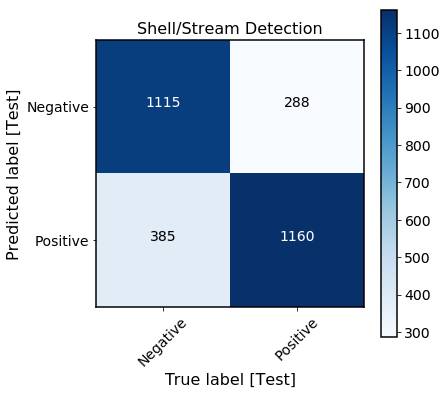

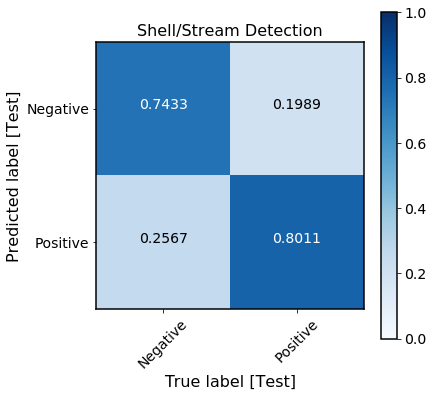

In [40]:
def plot_confusion_matrix(ax, cm, classes, update, version,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(np.sum(cm,axis=0)[:, np.newaxis])
    print(np.sum(cm,axis=0))
    
    if normalize:
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else :
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=16)
    cb = plt.colorbar(im1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #ax.text(0.5,0.05,'model_v{}_{}'.format(update,version),ha='center',va='bottom',
    #        transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    #ax.tight_layout()
    ax.set_ylabel('Predicted label [Test]',fontsize=16)
    ax.set_xlabel('True label [Test]',fontsize=16)

def print_confusion_matrix(out_test_class,tar_test,
                           randomState,version,update):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    np.set_printoptions(precision=3)


#     plt.rcParams["font.family"] = "Times New Roman"
#     plt.rcParams["font.size"] = 16

    # Plot non-normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plot_confusion_matrix(ax,cnf_matrix,classes=['Negative','Positive'], update=update, version=version,
                          title='Shell/Stream Detection')
    fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/ConfMatrix_RS-{}_v{}_{}.pdf'.format(randomState,version,update),bbox_inches='tight')

    ## Plot normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plot_confusion_matrix(ax,cnf_matrix, classes=['Negative','Positive'], update = update, version=version,
                          normalize=True, title='Shell/Stream Detection')
    fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/ConfMatrixNorm_RS-{}_v{}_{}.pdf'.format(randomState,version,update),bbox_inches='tight')




print_confusion_matrix(out_test_class,tar_test,randomState,version,update)

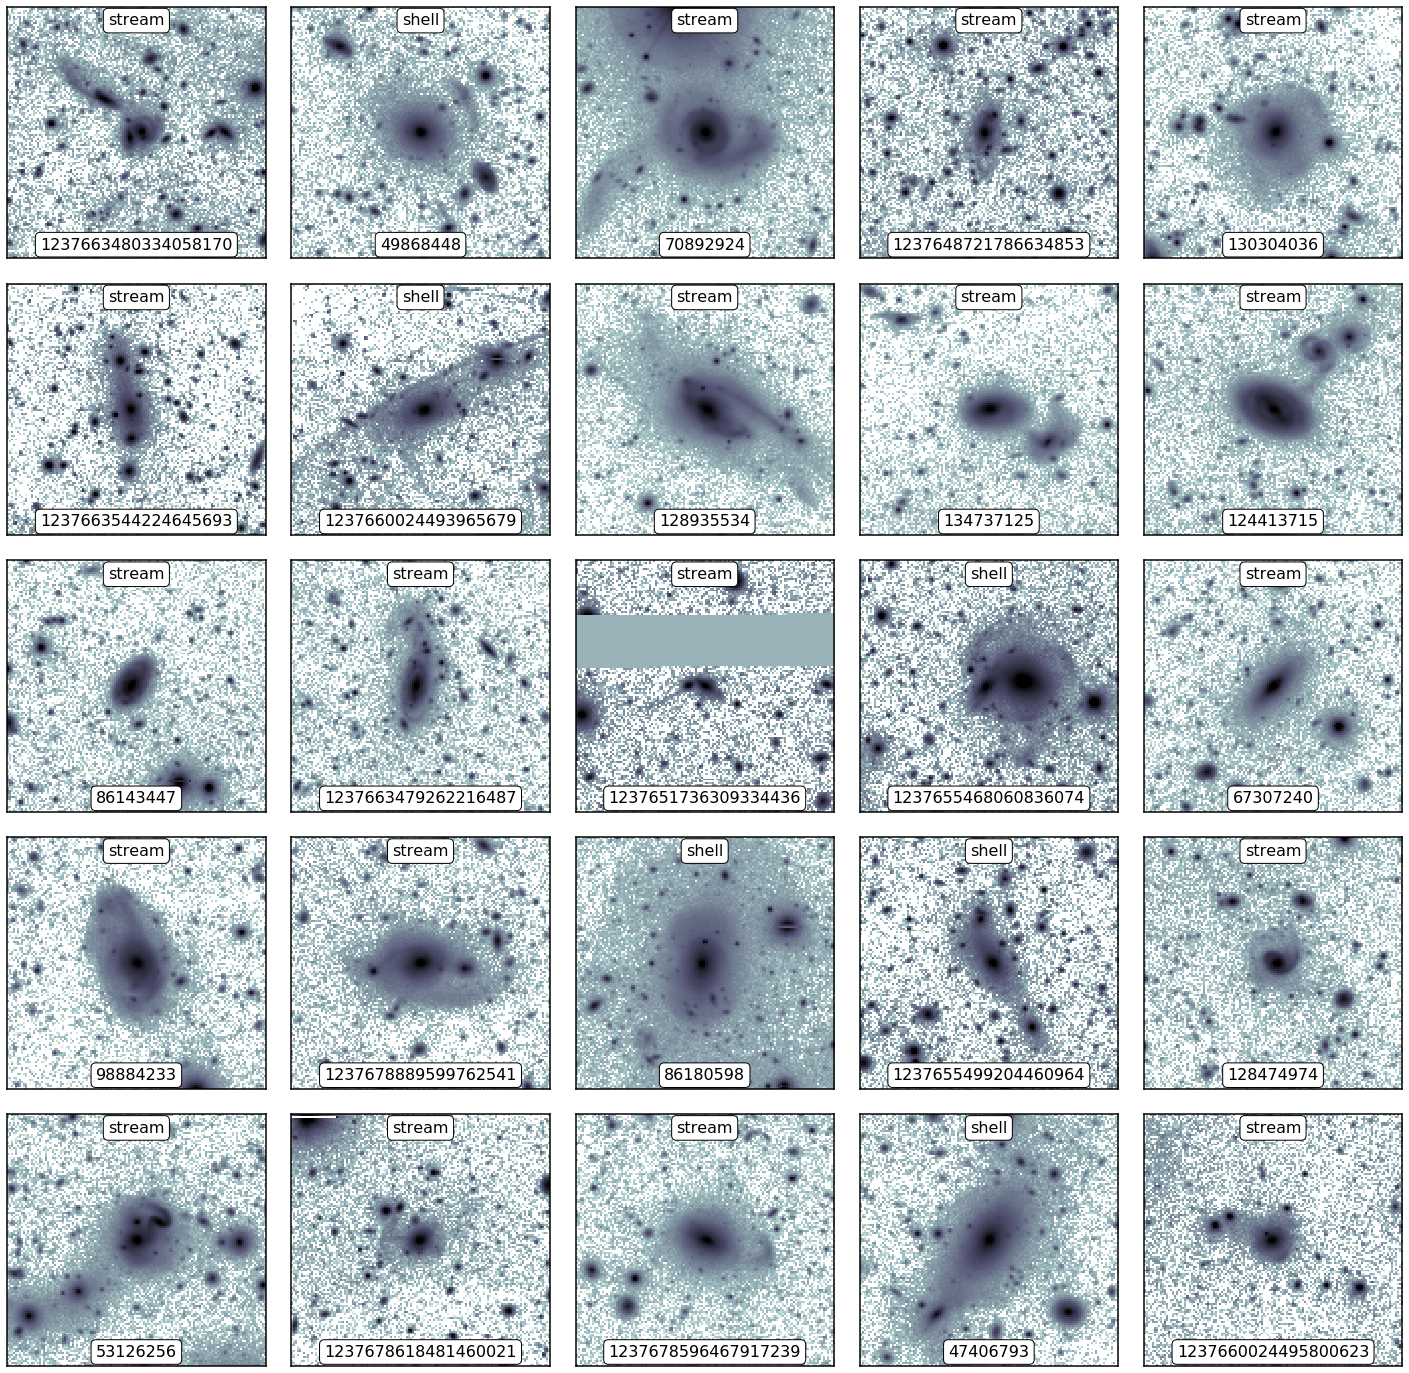

In [80]:
fig,axarr = plt.subplots(5,5,figsize=(25,25))
fig.subplots_adjust(wspace=0.1,hspace=0.1)
axarr = axarr.flatten()

positive_start = 1500
positive_end = 1500+181

negative_start = 0
negative_end = 750


indices = np.random.choice(np.arange(positive_start,positive_end),25,replace=False)

for ii, index in enumerate(indices):
    
    objID = cat_test[index,0]
    morphID = cat_test[index,1]
    
    axarr[ii].imshow(inp_test[index].reshape(128,128),vmin=0,vmax=1,cmap='bone_r',aspect='auto')
    
    axarr[ii].text(0.5,0.025,'{}'.format(objID),transform=axarr[ii].transAxes,ha='center',va='bottom',fontsize=16,
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    axarr[ii].text(0.5,0.975,'{}'.format(morphID),transform=axarr[ii].transAxes,ha='center',va='top',fontsize=16,
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    
    axarr[ii].get_yaxis().set_visible(False)
    axarr[ii].get_xaxis().set_visible(False)

fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/TP_RS-{}_v{}_{}.pdf'.format(randomState,version,update),bbox_inches='tight')